In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
# !pip install yfinance

In [4]:
tata_moto = pdr.get_data_yahoo('TATAMOTORS.NS', start = '2020-03-01')
tata_moto

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02 00:00:00+05:30,133.000000,133.899994,123.800003,125.400002,125.400002,111585697
2020-03-03 00:00:00+05:30,127.500000,131.399994,125.250000,130.350006,130.350006,86765576
2020-03-04 00:00:00+05:30,129.600006,129.600006,120.550003,126.199997,126.199997,97546902
2020-03-05 00:00:00+05:30,127.550003,129.149994,124.250000,125.750000,125.750000,87795649
2020-03-06 00:00:00+05:30,115.000000,117.300003,112.800003,114.199997,114.199997,83971462
...,...,...,...,...,...,...
2023-01-20 00:00:00+05:30,404.000000,412.500000,401.200012,403.149994,403.149994,23906114
2023-01-23 00:00:00+05:30,407.000000,410.950012,405.000000,408.399994,408.399994,13113183
2023-01-24 00:00:00+05:30,410.000000,424.000000,410.000000,422.149994,422.149994,30197475


In [5]:
tata_moto.to_csv('TATA_Motors.csv')

In [1]:
stock_data = pd.read_csv('TATA_Motors.csv')
stock_data.head()

NameError: name 'pd' is not defined

In [7]:
# As we are performing UniVariate Time Series Analysis so we will conside only close price.
stock_data = stock_data[['Date', 'Close']]

In [8]:
stock_data.head()

,Date,Close
0,2020-03-02 00:00:00+05:30,125.400002
1,2020-03-03 00:00:00+05:30,130.350006
2,2020-03-04 00:00:00+05:30,126.199997
3,2020-03-05 00:00:00+05:30,125.750000
4,2020-03-06 00:00:00+05:30,114.199997


In [9]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    724 non-null    object 
 1   Close   724 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.4+ KB


In [10]:
stock_data.Date = pd.to_datetime(stock_data.Date)
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype                                
---  ------  --------------  -----                                
 0   Date    724 non-null    datetime64[ns, pytz.FixedOffset(330)]
 1   Close   724 non-null    float64                              
dtypes: datetime64[ns, pytz.FixedOffset(330)](1), float64(1)
memory usage: 11.4 KB


In [11]:
stock_data = stock_data.set_index("Date")

In [12]:
stock_data['Close'].min()

65.30000305175781

In [13]:
stock_data[stock_data['Close'] == 65.30000305175781]

,Close
Date,
2020-04-03 00:00:00+05:30,65.300003


In [14]:
stock_data['Close'].max()

530.1500244140625

In [15]:
stock_data[stock_data['Close'] == 530.1500244140625]

,Close
Date,
2021-11-17 00:00:00+05:30,530.150024


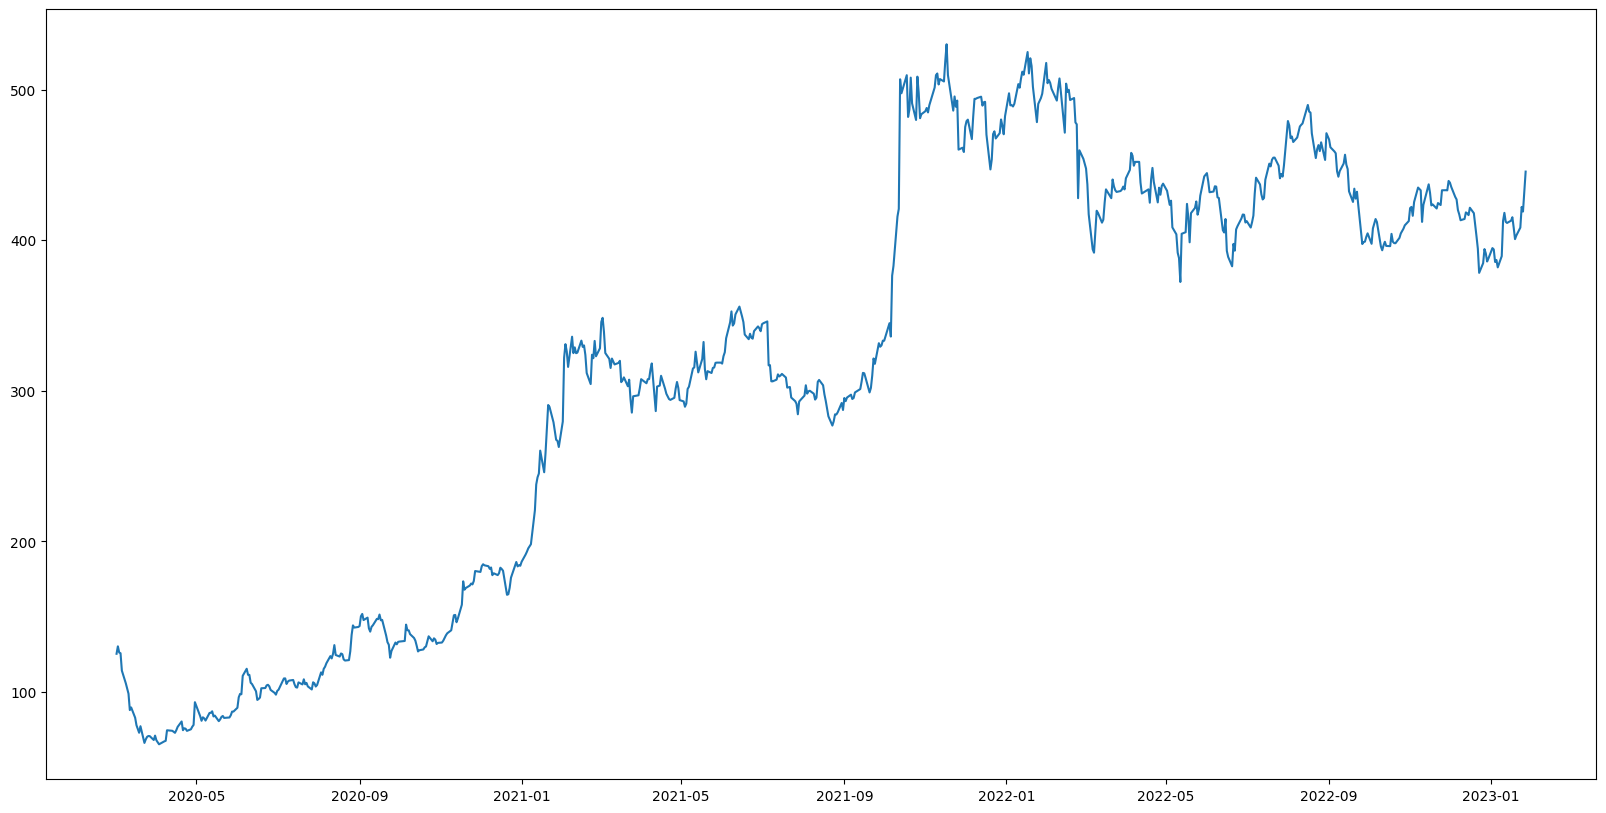

In [16]:
plt.figure(figsize = (20,10))
plt.plot(stock_data['Close'])

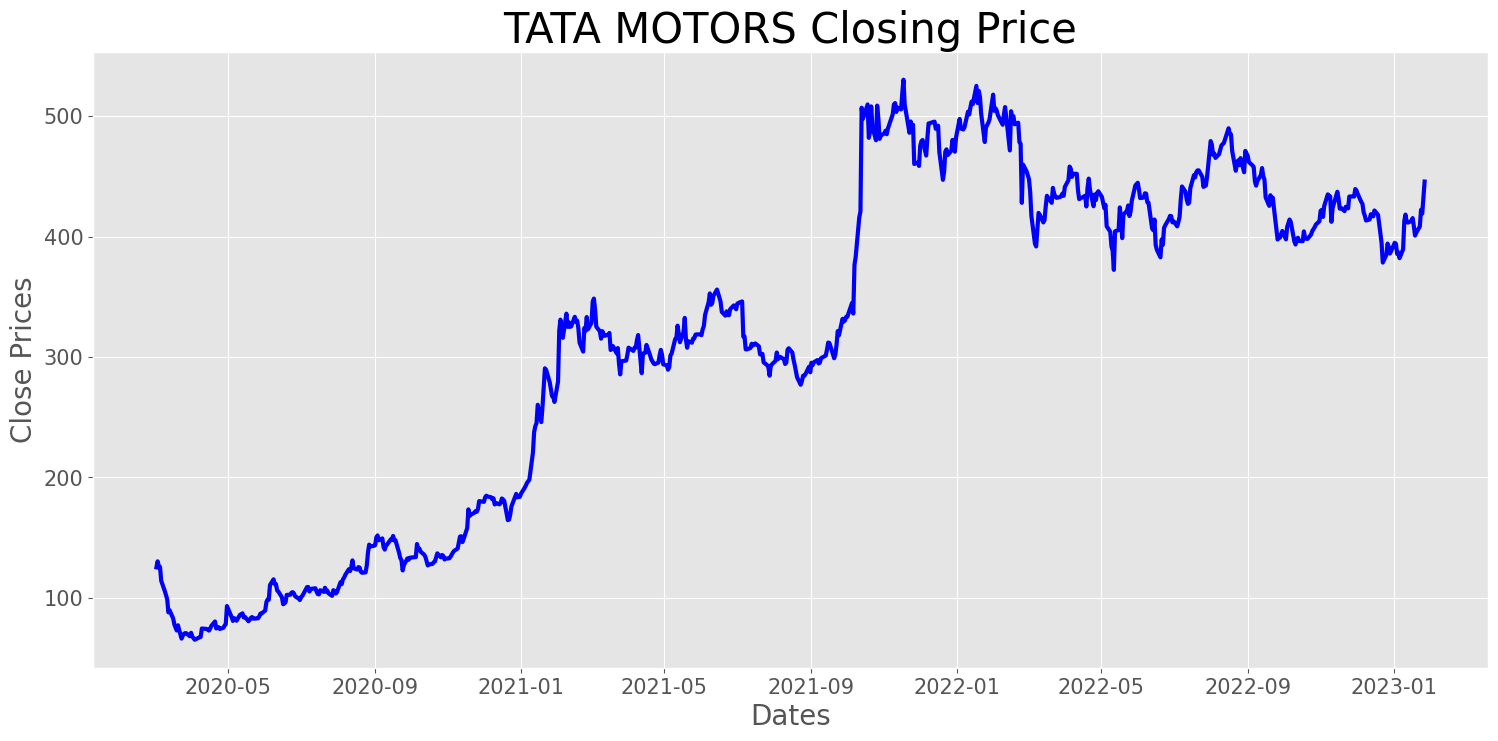

In [17]:
plt.style.use('ggplot')
plt.figure(figsize=(18, 8))
plt.grid(True)
plt.xlabel('Dates', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Close Prices', fontsize=20)
plt.yticks(fontsize=15)
plt.plot(stock_data['Close'], linewidth=3, color='blue')
plt.title('TATA MOTORS Closing Price', fontsize=30)
plt.show()

<AxesSubplot: xlabel='Close', ylabel='Density'>

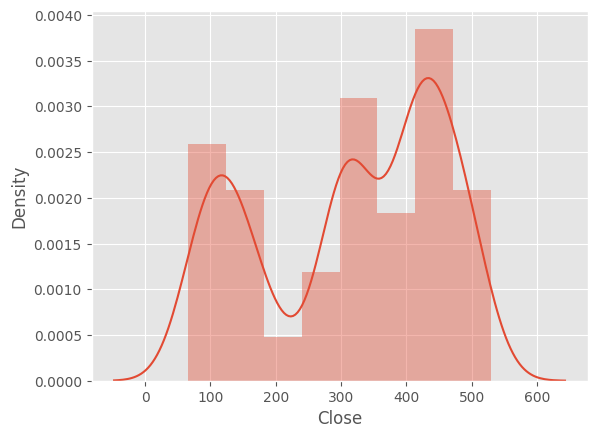

In [18]:
import seaborn as sns
sns.distplot(stock_data['Close'])

A probablity distribution can also be used to illustrate the data in our series

**ADF(Augmented Dickey Fuller TEST)**
to test Series is stationary or not. NULL Hypothesis: if the series has unit root Alt. Hypothesis: if the there is no unit root in the series. Series is non stationary if null hypothesis

In [19]:
stock_data

,Close
Date,
2020-03-02 00:00:00+05:30,125.400002
2020-03-03 00:00:00+05:30,130.350006
2020-03-04 00:00:00+05:30,126.199997
2020-03-05 00:00:00+05:30,125.750000
2020-03-06 00:00:00+05:30,114.199997
...,...
2023-01-20 00:00:00+05:30,403.149994
2023-01-23 00:00:00+05:30,408.399994
2023-01-24 00:00:00+05:30,422.149994


In [20]:
# mean of the 'Close' column data for 1st 12 days

np.mean(stock_data['Close'].head(12))

103.3874994913737

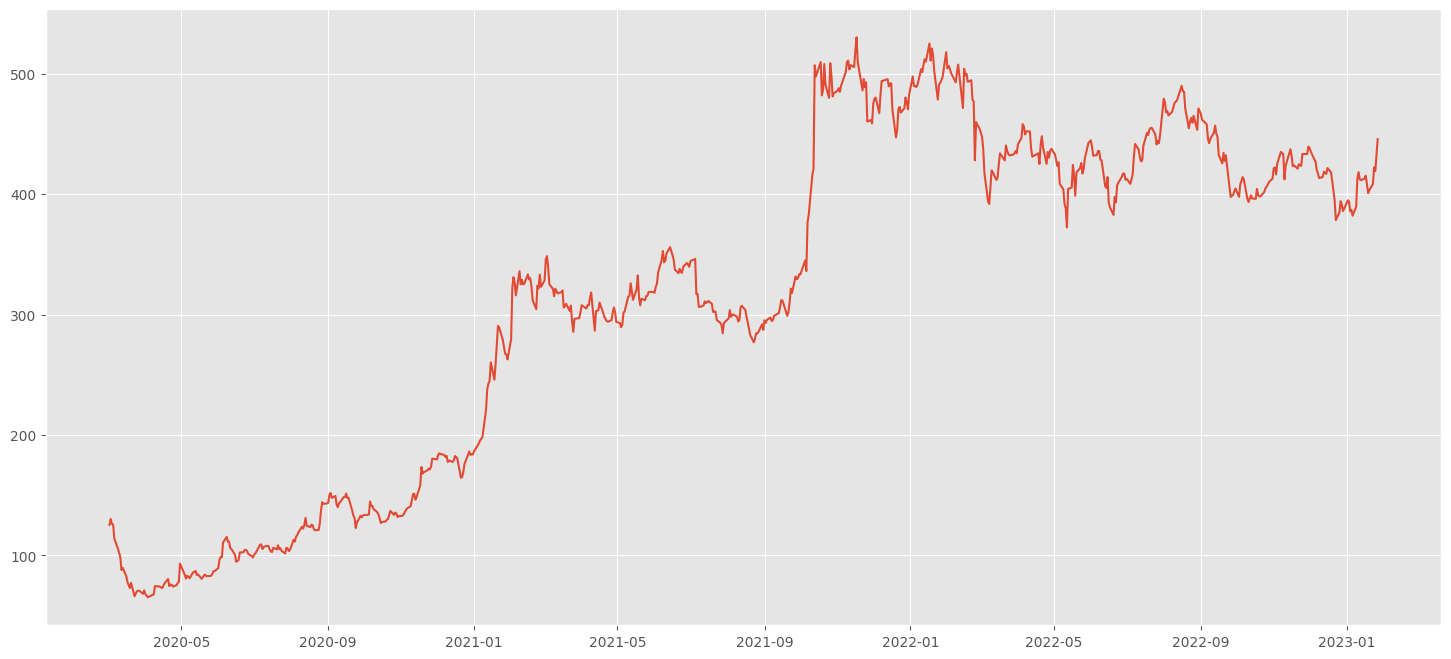

In [21]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Close'])

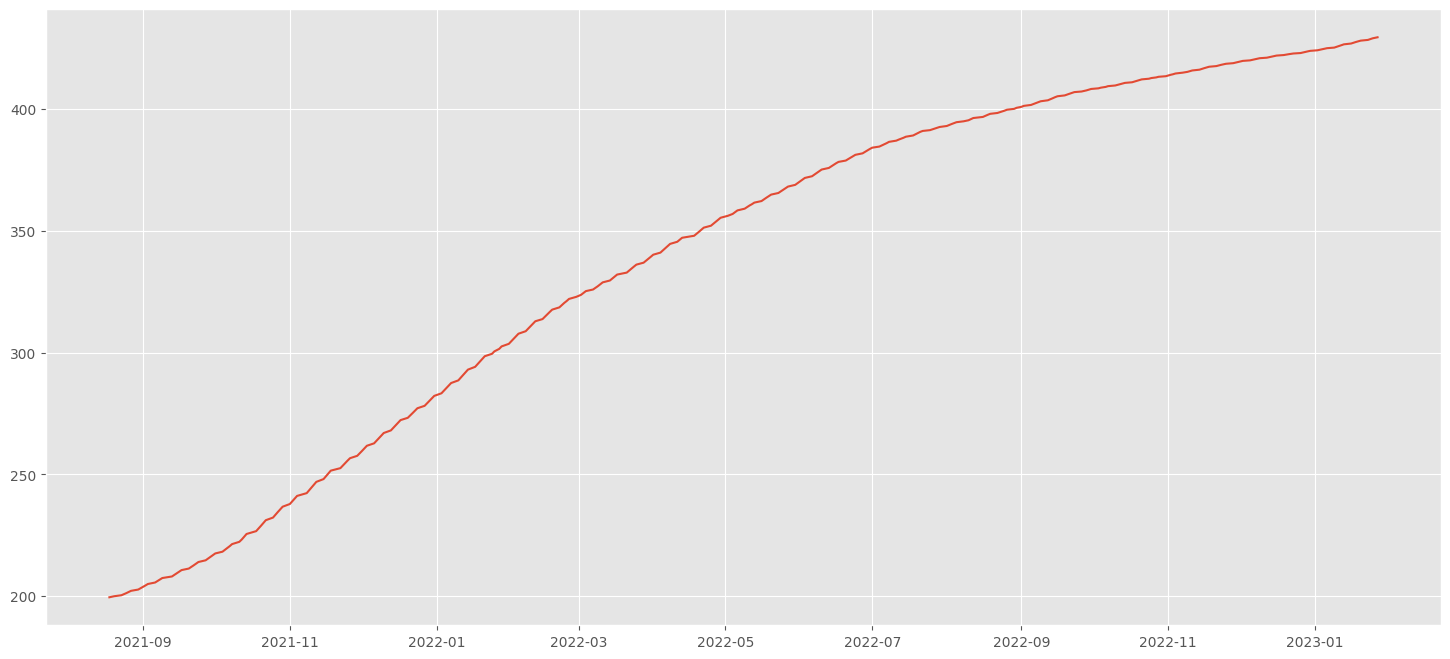

In [22]:
# Plotting mean where 'Window' = 365 (SMA)
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Close'].rolling(365).mean())

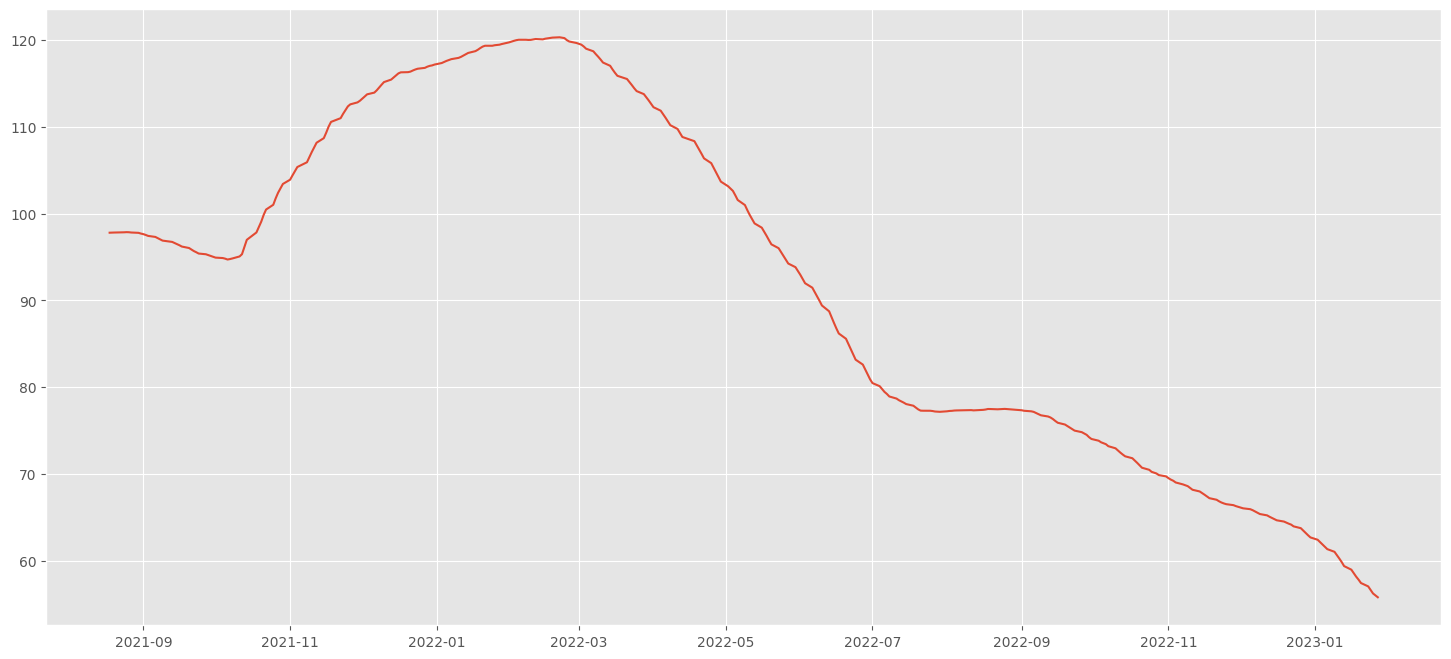

In [23]:
# Plotting Standard Deviation where window = 365 
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Close'].rolling(365).std())

In [24]:
# Adafuller test of the data to check stationary
# Adafuller test is a statistical significance test which means the test will give results in hypothesis tests with null and alternative h

adfuller(stock_data['Close'], autolag='AIC')

(-1.2231057510291232,
 0.6635780713737852,
 4,
 719,
 {'1%': -3.439477677285233,
  '5%': -2.865568186630048,
  '10%': -2.5689150720653977},
 5130.221328777585)

In [25]:
rolmean = stock_data.rolling(12).mean()
rolstd = stock_data.rolling(12).std()

In [26]:
# Function to Test for stationarity

def test_stationarity(timeseries):
  # Determining rolling statistics
  rolmean = rolmean = stock_data.rolling(12).mean() # Rolling mean
  rolstd = stock_data.rolling(12).std() ## Rolling Standard Deviation

  # Plot rolling statistics
  plt.figure(figsize=(18,8))
  plt.grid('both')
  plt.plot(timeseries, color='blue', label='Original', linewidth=3)
  plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=3)
  plt.plot(rolstd, color='black', label='Rolling Std', linewidth=4)
  plt.legend(loc='best', fontsize=20, shadow=True, facecolor='lightpink', edgecolor='k')
  plt.title('Rolling Mean and Standard Deviation', fontsize=25)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.show(block=False)

  print("Results of dickey fuller test")
  adft = adfuller(timeseries, autolag='AIC')
  # output for dft give us without defining what the values are.
  # hence we manually write what values does it explains using a for loop

  output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observation used'])
  for key, values in adft[4].items():
    output['critical value (%s)'%key] = values
  print(output)



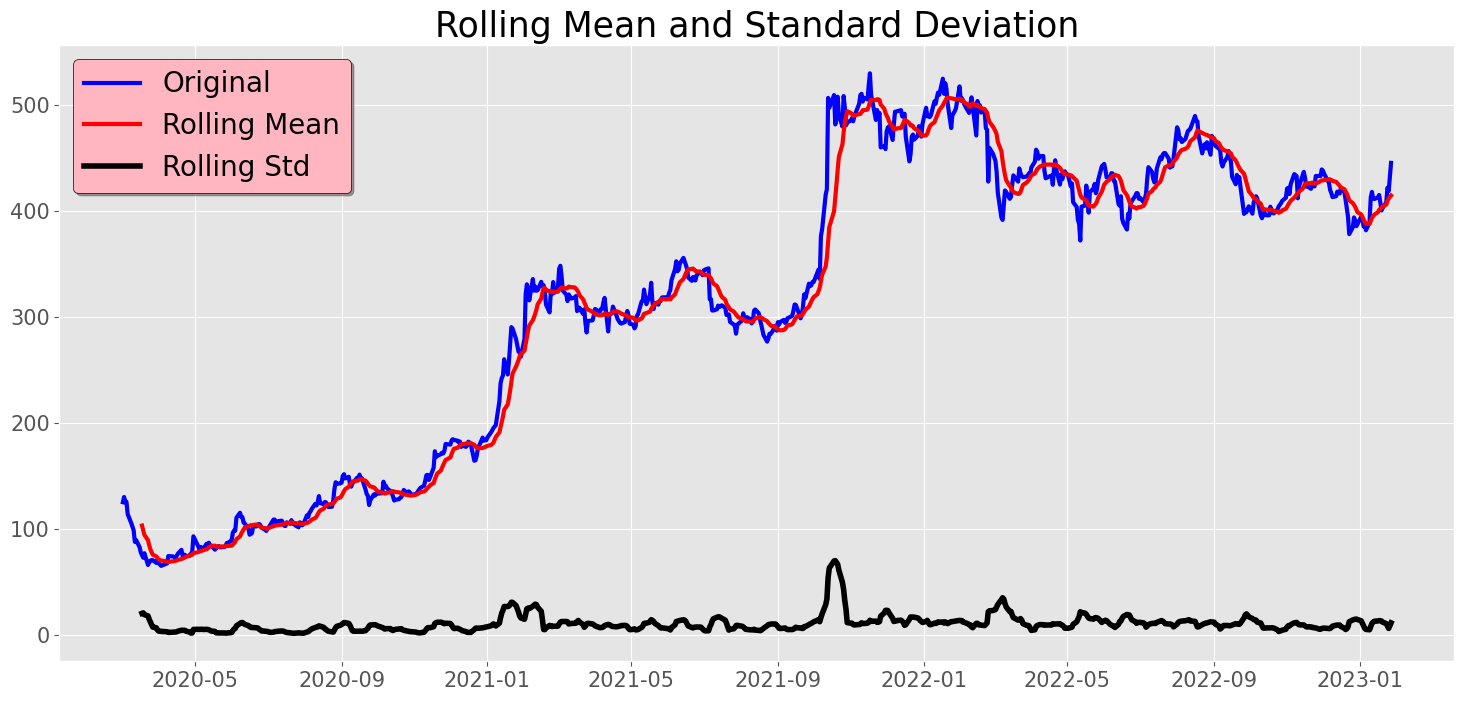

Results of dickey fuller test
Test Statistics                -1.223106
p-value                         0.663578
No. of lags used                4.000000
Number of observation used    719.000000
critical value (1%)            -3.439478
critical value (5%)            -2.865568
critical value (10%)           -2.568915
dtype: float64


In [27]:
test_stationarity(stock_data['Close'])

*We can't reject the null hypothesis because the p-value is bigger than 0.05. Futhermore, the test statistics exceed the critical values. As a result, the data is not stationary. Differencing is a method of transforming a non-stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model. So, to make the data stationary, we need to take the first-order difference of the data. substract today's close price from yesterday's close price.*

In [28]:
df_close = stock_data['Close']
df_close

Date
2020-03-02 00:00:00+05:30    125.400002
2020-03-03 00:00:00+05:30    130.350006
2020-03-04 00:00:00+05:30    126.199997
2020-03-05 00:00:00+05:30    125.750000
2020-03-06 00:00:00+05:30    114.199997
                                ...    
2023-01-20 00:00:00+05:30    403.149994
2023-01-23 00:00:00+05:30    408.399994
2023-01-24 00:00:00+05:30    422.149994
2023-01-25 00:00:00+05:30    419.049988
2023-01-27 00:00:00+05:30    445.600006
Name: Close, Length: 724, dtype: float64

In [29]:
df_close.diff()

Date
2020-03-02 00:00:00+05:30          NaN
2020-03-03 00:00:00+05:30     4.950005
2020-03-04 00:00:00+05:30    -4.150009
2020-03-05 00:00:00+05:30    -0.449997
2020-03-06 00:00:00+05:30   -11.550003
                               ...    
2023-01-20 00:00:00+05:30     2.399994
2023-01-23 00:00:00+05:30     5.250000
2023-01-24 00:00:00+05:30    13.750000
2023-01-25 00:00:00+05:30    -3.100006
2023-01-27 00:00:00+05:30    26.550018
Name: Close, Length: 724, dtype: float64

In [30]:
tata_moto_close_diff_1 = df_close.diff()

In [31]:
tata_moto_close_diff_1.isna().sum()

1

In [32]:
tata_moto_close_diff_1.dropna(inplace=True)

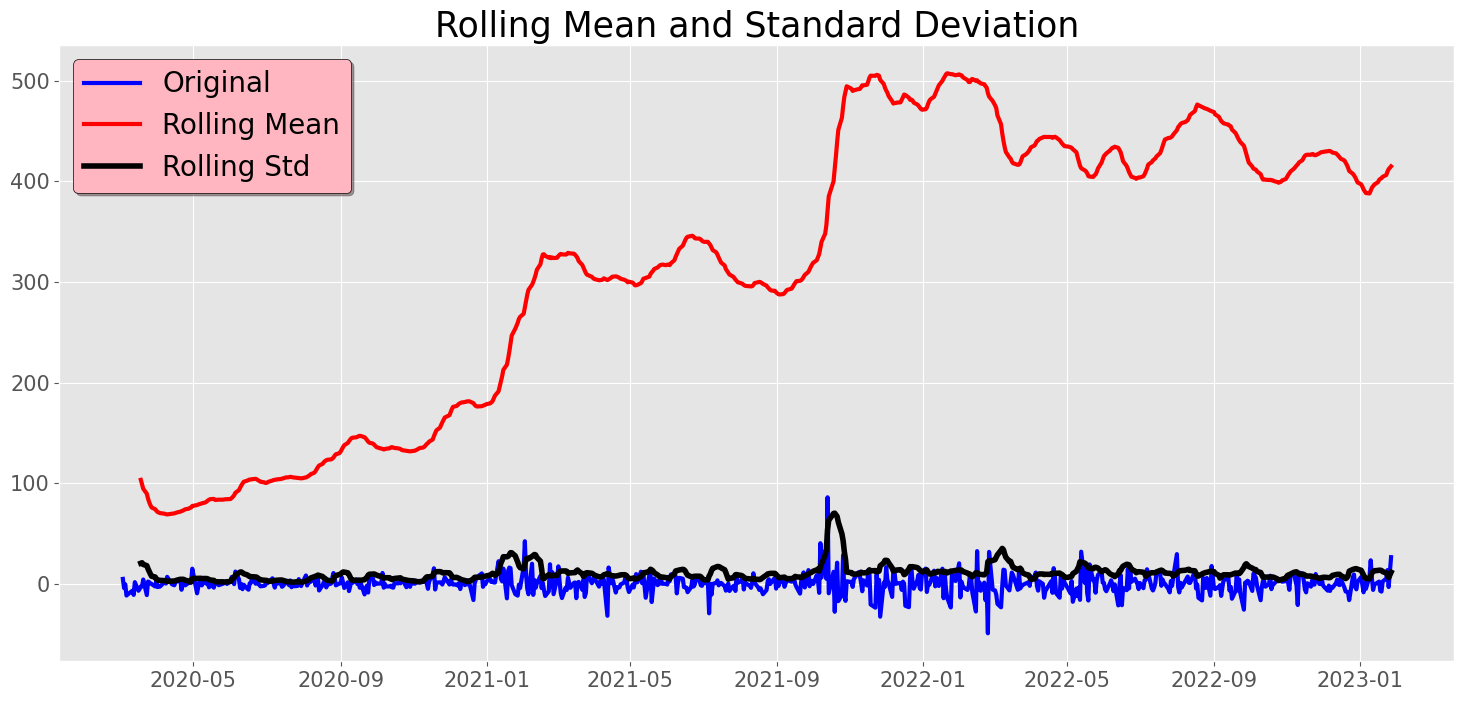

Results of dickey fuller test
Test Statistics              -1.296226e+01
p-value                       3.206930e-24
No. of lags used              3.000000e+00
Number of observation used    7.190000e+02
critical value (1%)          -3.439478e+00
critical value (5%)          -2.865568e+00
critical value (10%)         -2.568915e+00
dtype: float64


In [33]:
# Plot the tata motor Adj Close 1st order difference
test_stationarity(tata_moto_close_diff_1)

p-value is near to zero which defines stationary data

we will try to check the trend in the data
<ul>
<li>breakdown</li>
<li>season cycle</li>
<li>error as well</li>
</ul>
<p>
test statistics: -13.03410
</p>
<p>
The p-value is obtained is less than significance level of 0.05 and the ADF statistics is also lower than any critical values

We can reject the null hypothesis. So, the time series is in fact stationary

Decompose the time series: To start, we want to decompose the data to seperate the seasonality, trend and residual, since we have 3 years of stock data. We would expect there's a yearly and weekly pattern.</p>

In [34]:
result = seasonal_decompose(stock_data[['Close']], period=30) # no of days 

<Figure size 2000x1000 with 0 Axes>

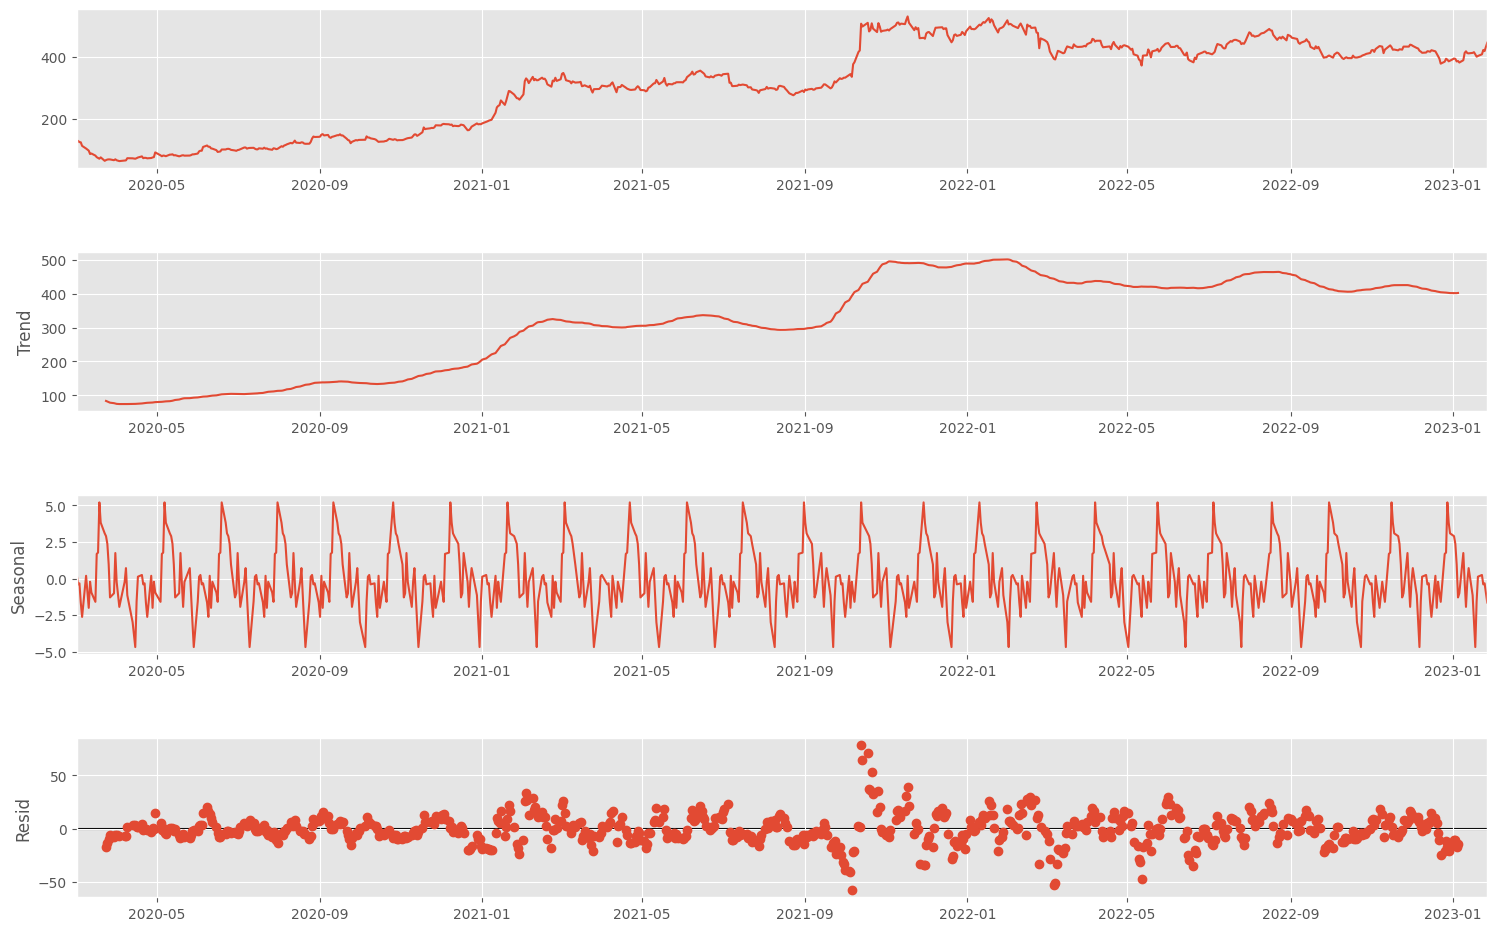

In [35]:
# Plottinng Trend, cycle, season, error -->> additive model
fig = plt.figure(figsize=(20,10))
fig = result.plot()
fig.set_size_inches(17,10)

<Figure size 2000x1000 with 0 Axes>

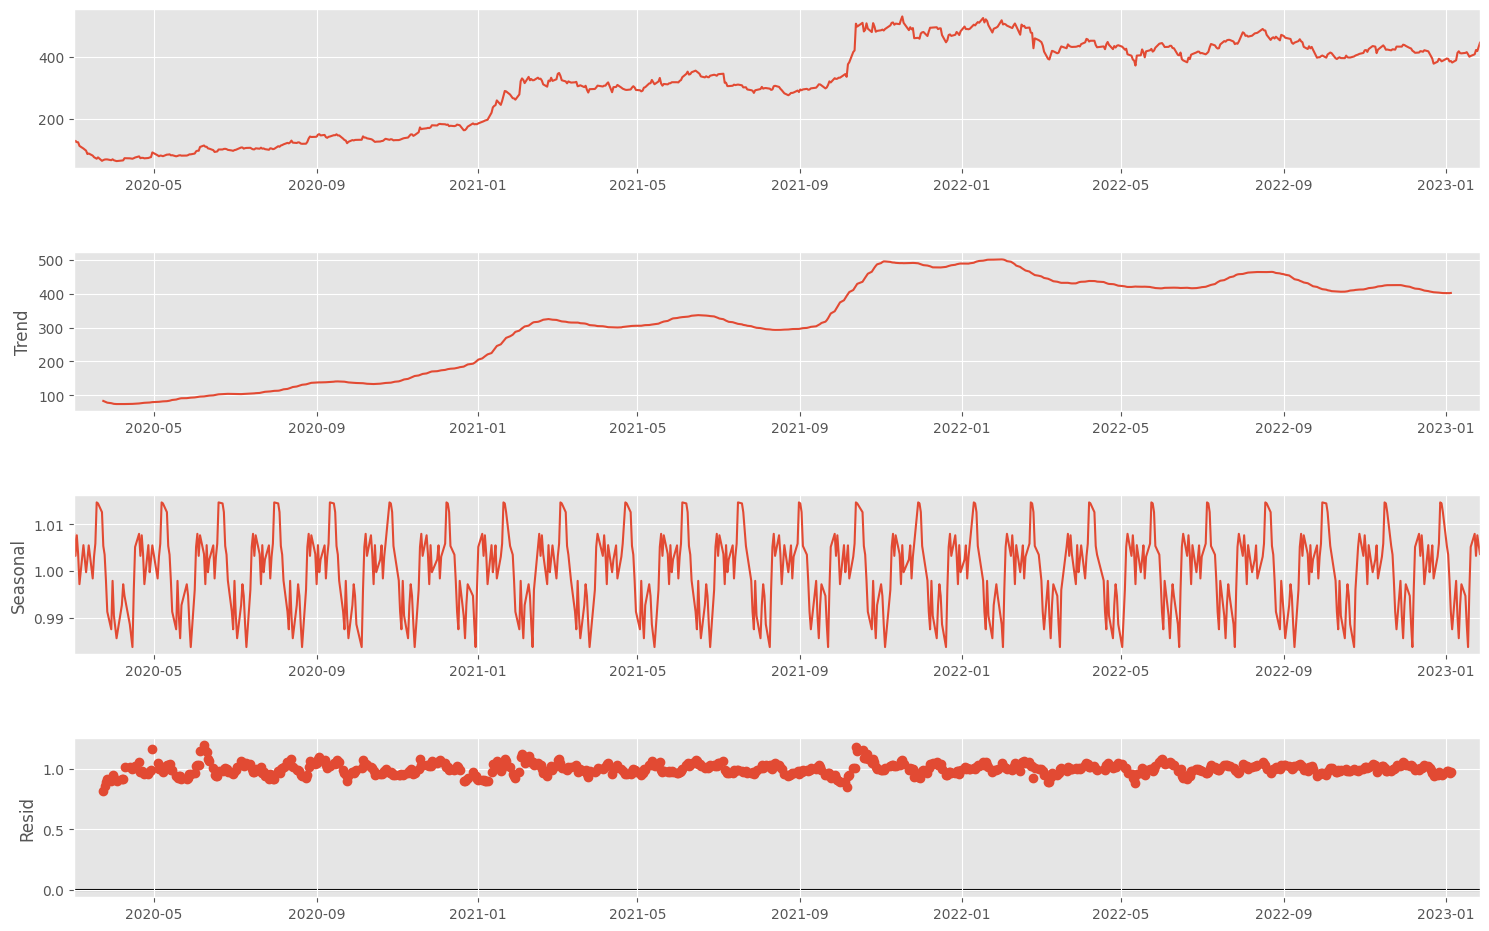

In [36]:
result = seasonal_decompose(stock_data[['Close']], period=30, model='multiplicative') # no of days 
# Plottinng Trend, cycle, season, error -->> additive model
fig = plt.figure(figsize=(20,10))
fig = result.plot()
fig.set_size_inches(17,10)

Now we'll create an ARIMA model and train it using train data's stock closing price. 

In [37]:
# preparing training data, where prediction will be after every 60 records
train_data = df_close[0:-60]

In [38]:
# preparing test data
test_data = df_close[-60:]

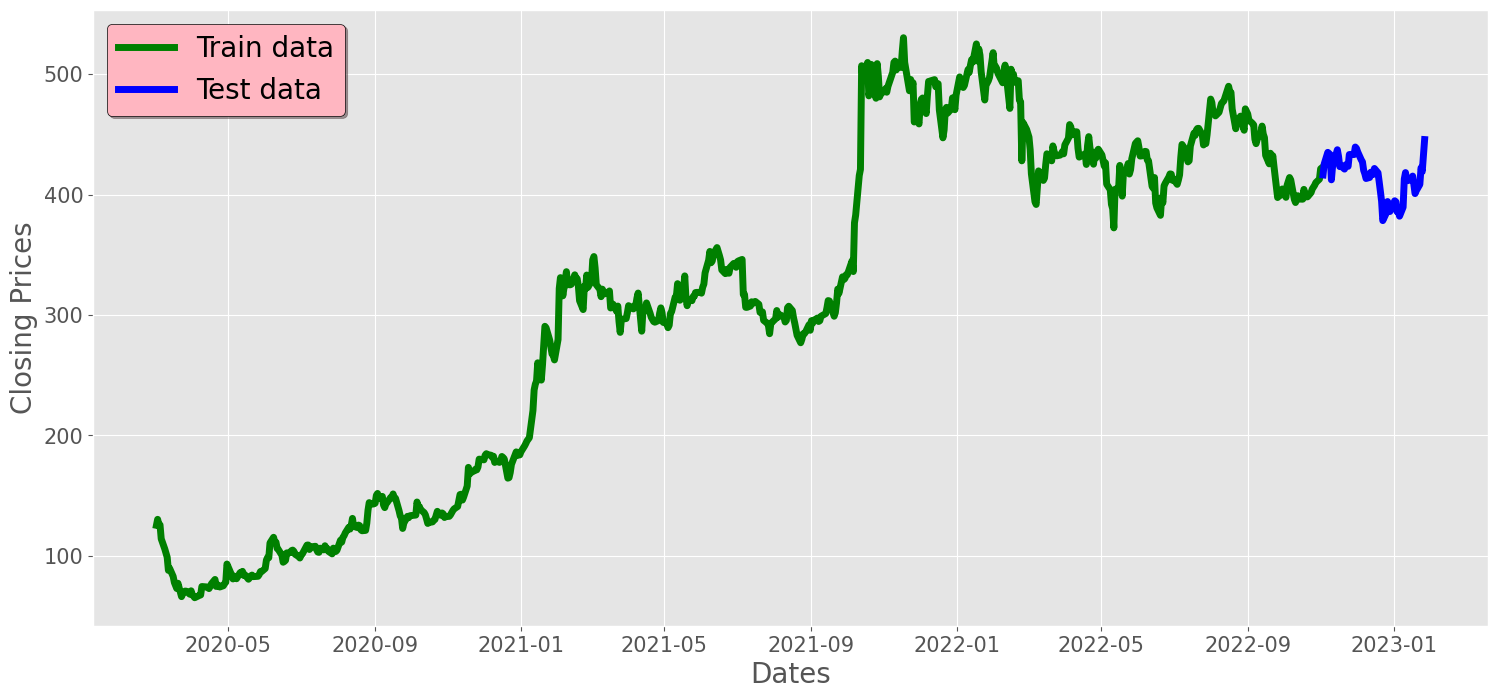

In [39]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Closing Prices', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(train_data, 'green', label='Train data', linewidth=5)
plt.plot(test_data, 'blue', label='Test data', linewidth=5)
plt.legend(fontsize = 20, shadow=True, facecolor='lightpink', edgecolor='k')

<h1>Auto-correlations</h1>


In [40]:
var1 = tata_moto_close_diff_1

In [41]:
var = tata_moto_close_diff_1[1:]

In [42]:
df = pd.DataFrame([var, var1])

In [43]:
df.T.corr

<bound method DataFrame.corr of                                Close      Close
Date                                           
2020-03-03 00:00:00+05:30        NaN   4.950005
2020-03-04 00:00:00+05:30  -4.150009  -4.150009
2020-03-05 00:00:00+05:30  -0.449997  -0.449997
2020-03-06 00:00:00+05:30 -11.550003 -11.550003
2020-03-09 00:00:00+05:30  -8.500000  -8.500000
...                              ...        ...
2023-01-20 00:00:00+05:30   2.399994   2.399994
2023-01-23 00:00:00+05:30   5.250000   5.250000
2023-01-24 00:00:00+05:30  13.750000  13.750000
2023-01-25 00:00:00+05:30  -3.100006  -3.100006
2023-01-27 00:00:00+05:30  26.550018  26.550018

[723 rows x 2 columns]>

In [44]:
# returns the cross correlation of two vectors
np.correlate(var1, var)

array([-1403.49037304, 61785.70721642])

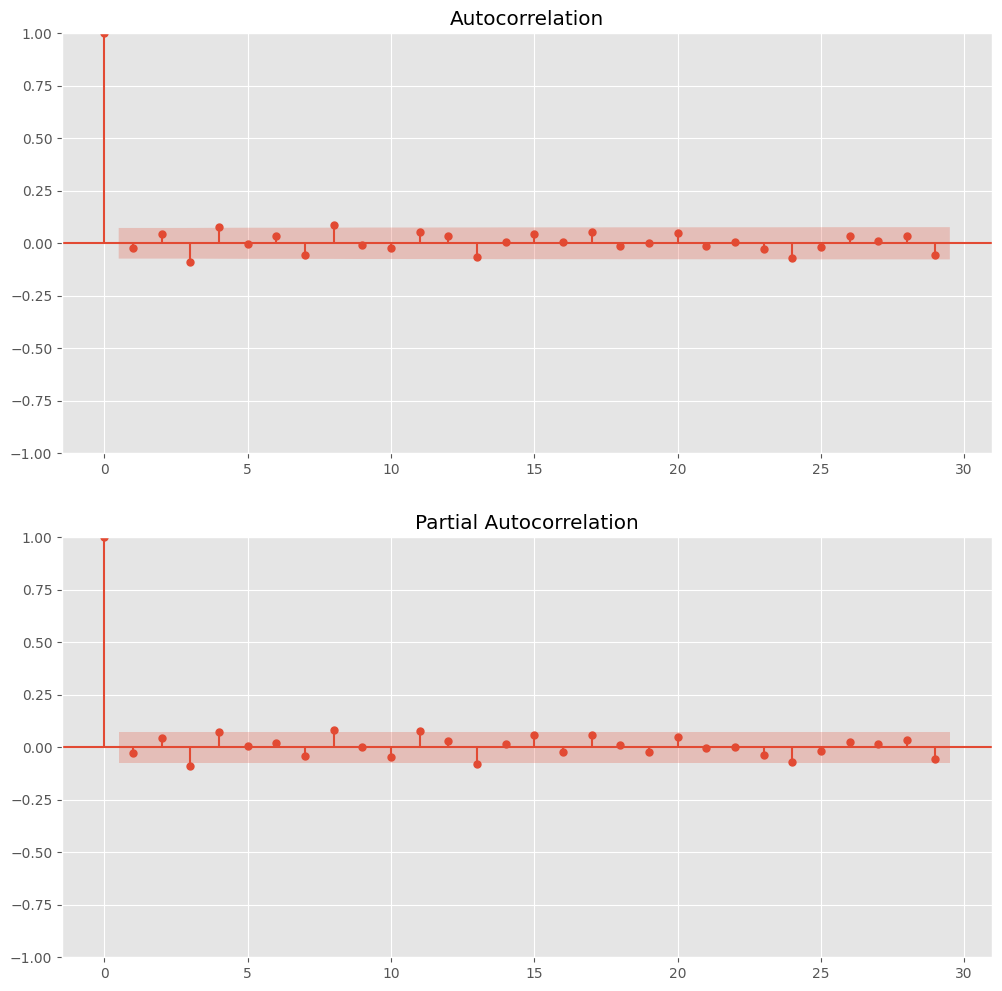

In [45]:
# plotting ACF and PACF graph
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(tata_moto_close_diff_1, ax= ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(tata_moto_close_diff_1, ax=ax2)

- To estimate the amount of AR terms(p), you need to look at the PACF plot. First, ignore the value at lag 0. It will always show a perfect correlation, since we are
estimating the correlation between today’s value with itself. Note that there is a coloured area in the plot, representing the confidence interval. To estimate how much
AR terms you should use, start counting how many spikes are above or below the confidence interval before the next one enter the coloured area. So, looking at the
PACF plot above, we can estimate to use 0 AR terms for our model, since no any spikes are out of the confidence interval.
- To calculate d, all you need to know how many differencing was used to make the series stationary. In our case, we have used order of 1st order differencing to
make our data stationary.
- To estimate the amount of MA terms (q), this time you will look at ACF plot. The same logic is applied here: how many spikes are above or below the confidence
interval before the next spike enters the coloured area? Here, we can estimate 0 MA terms, since no spike is out of the confidence interval.
So, we will use (0,1,0) order to fit ARIMA model.
We can also use different orders of p, d and q to get the best order with lowest AIC.

In [46]:
def evaluate_arima_model(X, y, arima_order):
    # preparing training dataset
    # make prediction list
    history = [x for x in X]
    predictions = list()

    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    
    # Calculate out of sample error
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

In [47]:
# evaluate different combinations of p, d and q values for an ARIMA model to get the best order for ARIMA model

def evaluate_model(dataset, test, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s, RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score) )

In [48]:
p_values = range(0, 3)

In [49]:
list(p_values)

[0, 1, 2]

In [50]:
d_values = range(0, 3)
q_values = range(0, 3)

In [51]:
warnings.filterwarnings("ignore")
evaluate_model(train_data, test_data, p_values, d_values, q_values)

ARIMA(0, 0, 0), RMSE=105.615
ARIMA(0, 0, 1), RMSE=55.160
ARIMA(0, 0, 2), RMSE=35.852
ARIMA(0, 1, 0), RMSE=7.979
ARIMA(0, 1, 1), RMSE=8.006
ARIMA(0, 1, 2), RMSE=8.073
ARIMA(0, 2, 0), RMSE=10.045
ARIMA(0, 2, 1), RMSE=7.983
ARIMA(0, 2, 2), RMSE=8.009
ARIMA(1, 0, 0), RMSE=7.987
ARIMA(1, 0, 1), RMSE=8.013
ARIMA(1, 0, 2), RMSE=8.081
ARIMA(1, 1, 0), RMSE=8.010
ARIMA(1, 1, 1), RMSE=8.066
ARIMA(1, 1, 2), RMSE=8.049
ARIMA(1, 2, 0), RMSE=9.947
ARIMA(1, 2, 1), RMSE=8.014
ARIMA(1, 2, 2), RMSE=8.072
ARIMA(2, 0, 0), RMSE=8.016
ARIMA(2, 0, 1), RMSE=8.073
ARIMA(2, 0, 2), RMSE=8.036
ARIMA(2, 1, 0), RMSE=8.092
ARIMA(2, 1, 1), RMSE=8.055
ARIMA(2, 1, 2), RMSE=8.038
ARIMA(2, 2, 0), RMSE=9.491
ARIMA(2, 2, 1), RMSE=8.089
ARIMA(2, 2, 2), RMSE=8.053
Best ARIMA(0, 1, 0) RMSE=7.979


In [52]:
# Best ARIMA order
arima_order = (0,1,0)

In [54]:
history = [x for x in train_data]
history

[125.4000015258789,
 130.35000610351562,
 126.1999969482422,
 125.75,
 114.1999969482422,
 105.6999969482422,
 98.9000015258789,
 88.0,
 89.75,
 82.94999694824219,
 77.94999694824219,
 75.5,
 72.94999694824219,
 77.30000305175781,
 66.19999694824219,
 68.55000305175781,
 70.25,
 70.80000305175781,
 70.69999694824219,
 68.1500015258789,
 71.05000305175781,
 67.94999694824219,
 65.30000305175781,
 67.25,
 67.5999984741211,
 74.5999984741211,
 74.25,
 72.9000015258789,
 74.6500015258789,
 76.8499984741211,
 80.44999694824219,
 74.6500015258789,
 75.9000015258789,
 75.6500015258789,
 74.19999694824219,
 75.25,
 76.94999694824219,
 78.1500015258789,
 93.25,
 83.9000015258789,
 80.9000015258789,
 83.19999694824219,
 82.5,
 81.05000305175781,
 86.0999984741211,
 86.19999694824219,
 87.19999694824219,
 83.80000305175781,
 84.3499984741211,
 80.6500015258789,
 81.80000305175781,
 83.44999694824219,
 84.0999984741211,
 82.80000305175781,
 83.0999984741211,
 84.55000305175781,
 87.0,
 87.0,
 89.5